In [ ]:
pip install transformers
pip install accelerate
pip install datasets
pip install evaluate
pip install seqeval
pip install spacy

# Agenda

1. [[Theory] Transformer Types. Cross-attention and Self-attention. Language Models](#Transformer_Types)
2. [Hugging Face](#Hugging_Face)
3. [Sentence classification with Transformers](#Sentence_classification_with_Transformers)
4. [[Theory] Intro to GPT](#gpt_intro)

<a id='Transformer_Types'></a>
# [Theory] Transformer Types. Cross-attention and Self-attention. Language Models

For example, suppose we had the following sentences:

- On the river bank
- On the bank of the river

An LSTM or RNN wouldn’t realize that in the context of the second sentence, the word bank is referring to a location by a stream of water and not a financial institution. In contrast, a transformer is able to handle this scenario because it doesn’t read the words one after the other. Rather, it accepts the entire sentence at once.

## RNN vs Transformer processing

<table>
    <tr>
        <td><img src='https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-words.png' style='width: 300px;'/></td>
        <td><img src='https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png' style='width: 300px;'/></td>
    </tr>
</table>

## Complete Transformer architecture
- Encoder
- Decoder

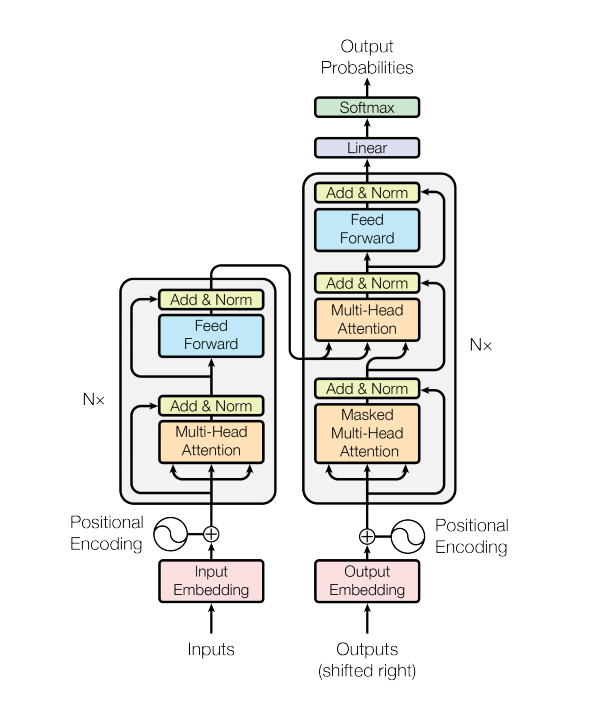

## Input Encoding

Consists of two embeddings:
- Word Embeddings - Embedding Matrix (Previous Lecture)
- Positional Embedding

### Positional Embedding

Embeddings represent a token in a d-dimensional space where tokens with similar meaning are closer to one another. However, the embeddings do not encode the relative position of the tokens in a sentence.

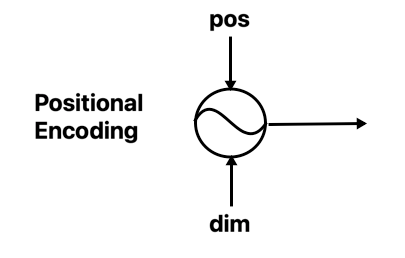

Formula:

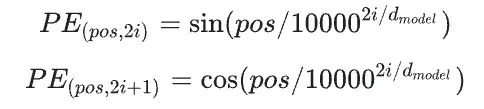

Positional encoding works because absolute position is less important than relative position. For instance, we don’t need to know that the word “good” is at index 6 and the word “looks” is at index 5. It’s sufficient to remember that the word “good” tends to follow the word “looks”.

Here’s a plot generated using a sequence length of 100 and embedding space of 512 dimensions:

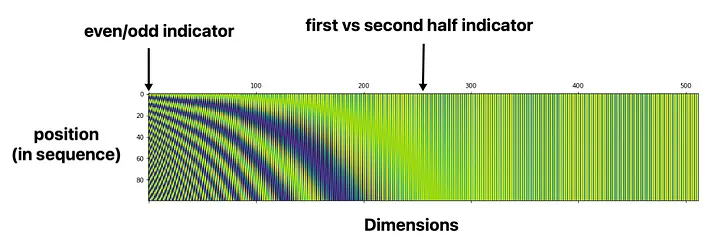

For the first dimension, if the value is 1, it’s an odd word, if the value is 0, it’s an even word. For the d/2th dimension, if the value is 1, we know the word is in the second half of the sentence and if the value is 0, then it’s in the first half of the sentence. The model can use this information to determine the relative position of the tokens.

**Final Encoding**

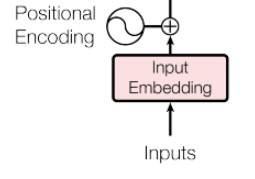

## Encoder

The Encoder’s job is to map all input sequences into an abstract continuous representation that holds the learned information (i.e. how words relate to one another).

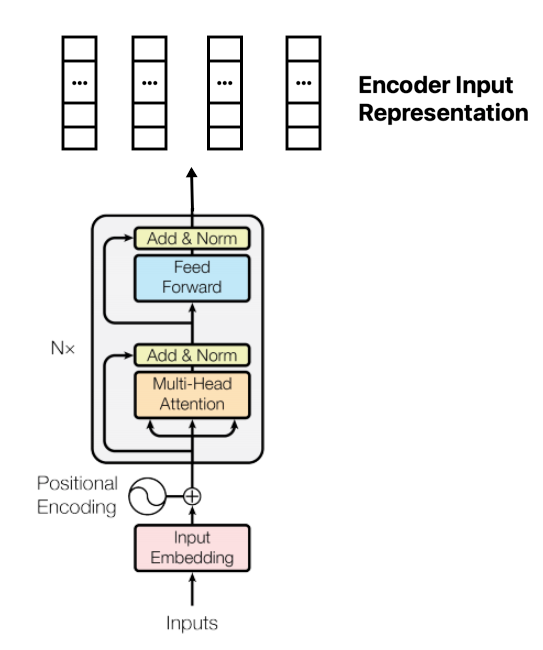

### Self-Attention Transformer

It is simply a Transformer, which consists of Input Encoding -> Encoder -> Final Classification layer

> **TODO**: Read more details : https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a

### Scaled Dot-Product Attention

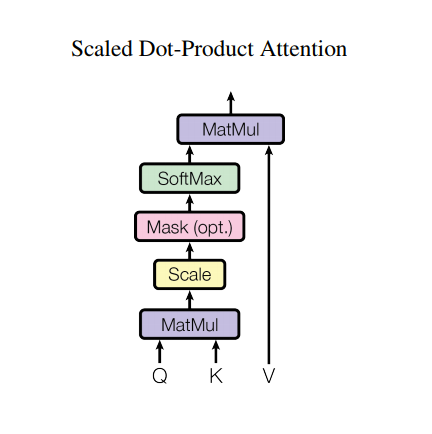

After feeding the query, key, and value vectors through a linear layer, we calculate the dot product of the query and key vectors. The values in the resulting matrix determine how much attention should be payed to the other words in the sequence given the current word. In other words, each word (row) will have an attention score for every other word (column) in the sequence.

> **TODO**: Why should we pass inputs through different linear layer?

> **TODO**: Why dot product works for computing attention?

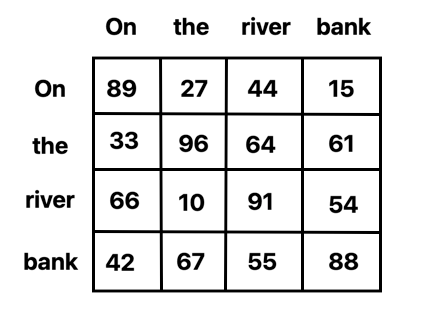

The dot product is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients which make it difficult to learn.

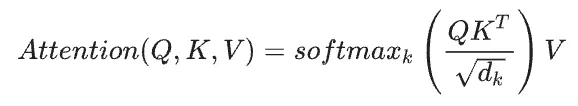

Once the values have been scaled, we apply a softmax function to obtain values between 0 and 1.

> **TODO**: Along which dimension softmax was applied? How can we check it?

![image.png](https://i.imgur.com/ZM93ezX.png)

Finally, we multiply the resulting matrix by the value vector.

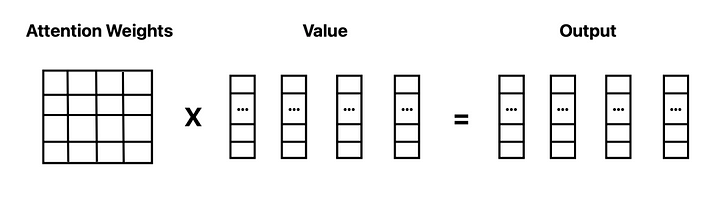

> **TODO**: Can you explain in simple words: What do we get after the final multiplication?

## Multi-Headed Attention

Instead of one single attention head, Q, K, and V are splitted into multiple heads, because it allows the model to jointly attend to information from different representation subspaces at different positions. Splitting is performed by introducing different Linear layers and performing Scaled Dot-Product Attention for each separately. 

For example, given the word “the”, the first head will give more attention to the word “bank” whereas the second head will give more attention to the word “river”.

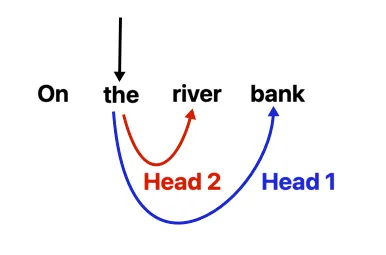

It’s important to note that after the split each head has a reduced dimensionality. Thus, the total computation cost is the same as a single head attention with full dimensionality. So if in casual setup you have used ONE `D` dimension linear projection, in Multi-Head - you will use `N` linear projections with dims - `D/N`

The attention output for each head is concatenated and put through a Dense layer.

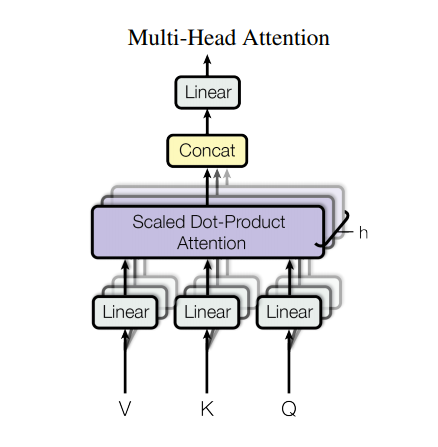

## The Residual Connections, Layer Normalization, and Feed Forward Network

The original positional input embedding is added to the multi-headed attention output vector. This is known as a residual connection. Each hidden layer has a residual connection around it, followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

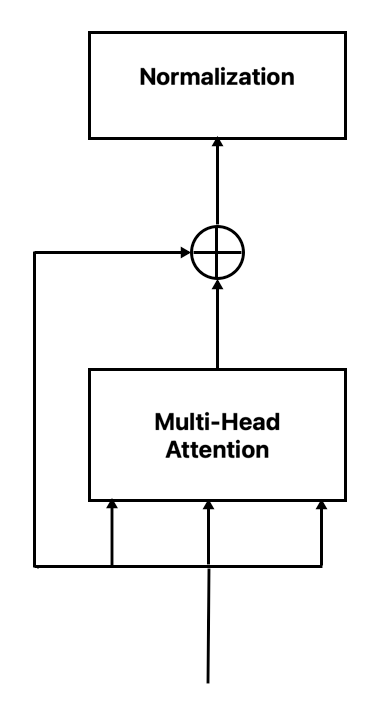

The output finishes by passing through a pointwise feed forward network.

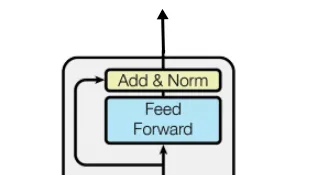

## Decoder

The decoder’s job is to generate text. The decoder has similar hidden layers to the encoder. However, unlike the encoder, the decoder’s output is sent to a softmax layer in order to compute the probability of the next word in the sequence.

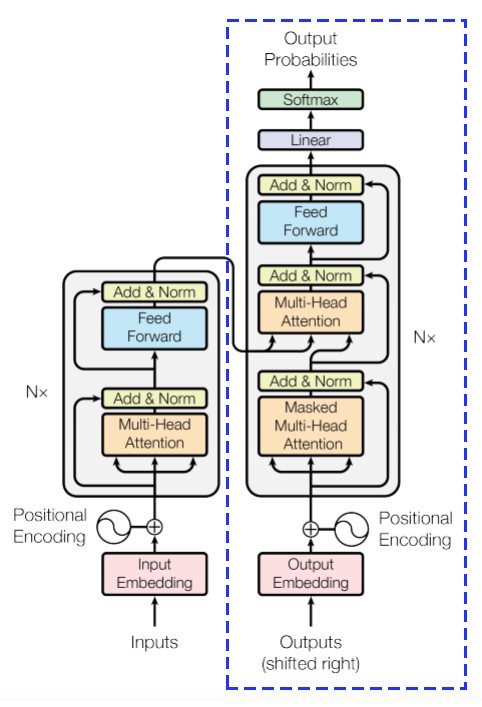

Detailed image, from which sequences we take Keys, Queries and Values. Concept explained on Translation task:



So assume we have access to the WHOLE input text sequence in English and we want to translate it to German:
1. We will do it word by word - we'll compute the first word of our German translation, then the second one and so on. Note that by doing it this way, our German translation does not need to have the same number of words as the English one, nor it needs to follow its word order. This kind of flexibility is the main advantage of cross-attention.
2. So, to get our first German word we generate a "query" vector (out of the blue), which in some sense means something like: "To which words in the input sequence I need to pay attention to have a good guess about how to begin my German translation?".
3. In the meantime, another neural network has produced a "key" and a "value" vectors for each English word, taking into account its position in the input sentence.
4. Now you compare your "query" vector from step 2 to each of those "keys". In essence, every "key" encodes some information about its corresponding English word, that could be relevant to different queries. For example, in this particular case, each "key" has some information about HOW IMPORTANT the corresponding English word is to figure out the FIRST word in our German translation. In other words, after comparing our first "query" to ALL the "keys", we end up with a set of weights for every corresponding input English word.
5. Now that we've identified English words in the input sequence that are important to generate our first German word, we multiply the weights obtained in the previous step by "values" of the corresponding English words (obtained in step 3) and add them up. In essence, "keys" were telling us WHICH English words are important with respect to our "query", while "values" of those words contain information about WHAT exactly needs to be extracted from those relevant words. 
6. Now we transform the vector obtained in step 5 (sum of "values" of relevant English words, according to our first "query") in some fixed way to arrive to our first German word. Hurrah!
7. Now that we have our first German word, we encode it in some way and use it to produce our "query" #2 (i.e. not out of the blue this time). This "query" will help us search for relevant words in the input Englush sequence to generate the second German word, but also taking into account the first German word we have generated earlier.
8. You get the idea: repeat steps 4-6 with "query" #2, then "query" #3 and so on, until we've generated every word of our output German translation.

Detailed explanation - https://vaclavkosar.com/ml/cross-attention-in-transformer-architecture

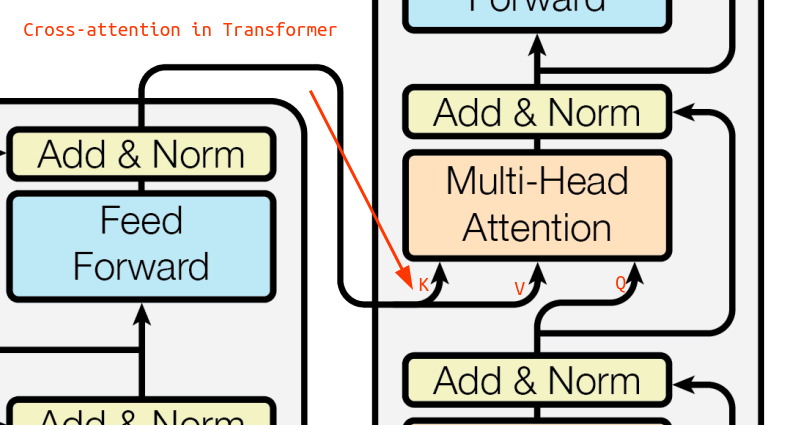

## Decoder Input Embeddings & Positional Encoding

The decoder is autoregressive meaning that it predicts future values based on previous values. To be exact, the decoder predicts the next token in the sequence by looking at the encoder’s output and self-attending to its own previous output. Just like we did with the encoder, we add the positional encodings to the word embedding to capture the position of the tokens in the sentence. **Pay attention to the phrase "shifted right" on the image**

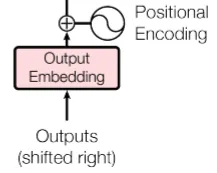

## Masking

Since the decoder is trying to generate the sequence word by word, a look-ahead mask is used to indicate which entries should not be used. For example, when predicting the third token in the sentence, only the previous tokens, that is, the first and second tokens, should be used.

![image.png](https://i.imgur.com/0PkmxkA.png)

## Output

Like we mentioned previously, the output of the hidden layers goes through a final softmax layer. If we have a vocabulary of 10,000 words, then the output of the classifier will be a vector of length 10,000 where the value at each index is the probability that the word associated with that index is the next word in the sequence.

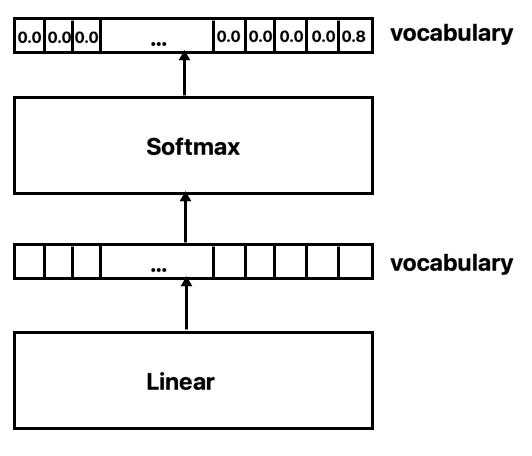

We take the word with the highest probability and append it to the sequence used in the next training iteration.

> **TODO**: Read about other sampling methods - https://medium.com/nlplanet/two-minutes-nlp-most-used-decoding-methods-for-language-models-9d44b2375612

In [1]:
from torch.nn import Transformer

Transformer()

/home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Transformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, o

# Language Modelling

Language modeling is the task of predicting the next word or character in a document. This technique can be used to train language models that can further be applied to a wide range of natural language tasks like text generation, text classification, and question answering. 

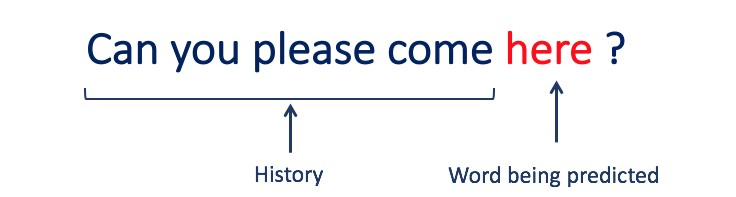

> **TODO**: Read about mathematical background of language modelling https://en.wikipedia.org/wiki/Language_model. Probability Theory works pretty cool there!

<a id='Hugging_Face'></a>
# [Hugging Face](https://huggingface.co/)

It is a big community, which provides:
- The most popular Transformer repo - https://github.com/huggingface/transformers
- Hub with pre-trained models - https://huggingface.co/models
- Hub with datasets - https://huggingface.co/datasets
- Spaces - where you can publish your model or try other peoples' published models - https://huggingface.co/spaces
- Some commercial solutions

We will use the first pair

## Transfer Learning (in a short)

Original article - https://machinelearningmastery.com/transfer-learning-for-deep-learning/

**What does it mean "Pre-trained models" ???**

Lets take a look at the concept of Transfer Learning

Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task.

It is a popular approach in deep learning where pre-trained models are used as the starting point on computer vision and natural language processing tasks given the vast compute and time resources required to develop neural network models on these problems and from the huge jumps in skill that they provide on related problems.

### Pipeline how to use Transfer Learning


1. **Select Source Model.** A pre-trained source model is chosen from available models. Many research institutions release models on large and challenging datasets that may be included in the pool of candidate models from which to choose from.
2. **Reuse Model.** The pre-trained model can then be used as the starting point for a model on the second task of interest. This may involve using all or parts of the model, depending on the modeling technique used.
3. **Tune Model.** Optionally, the model may need to be adapted or refined on the input-output pair data available for the task of interest.

### Tranfer Learning Use-Cases

- **Transfer Learning with Image Data:** For example this may be a prediction task that takes photographs or video data as input. For these types of problems, it is common to use a deep learning model pre-trained for a large and challenging image classification task such as the [ImageNet](https://image-net.org/) 1000-class photograph classification competition. This approach is effective because the images were trained on a large corpus of photographs and require the model to make predictions on a relatively large number of classes, in turn, requiring that the model efficiently learn to extract features from photographs in order to perform well on the problem.
- **Transfer Learning with Language Data:** It is common to perform transfer learning with natural language processing problems that use text as input or output. For these types of problems, a word embedding is used. It is just a mapping of words to a high-dimensional continuous vector space where different words with a similar meaning have a similar vector representation. Pre-trained models are mostly trained on Language modelling tasks, so they should keep well structed context information in their word embeddings.

### Benefits from Transfer Learning


1. **Higher start.** The initial skill (before refining the model) on the source model is higher than it otherwise would be.
2. **Higher slope.** The rate of improvement of skill during training of the source model is steeper than it otherwise would be.
3. **Higher asymptote.** The converged skill of the trained model is better than it otherwise would be.

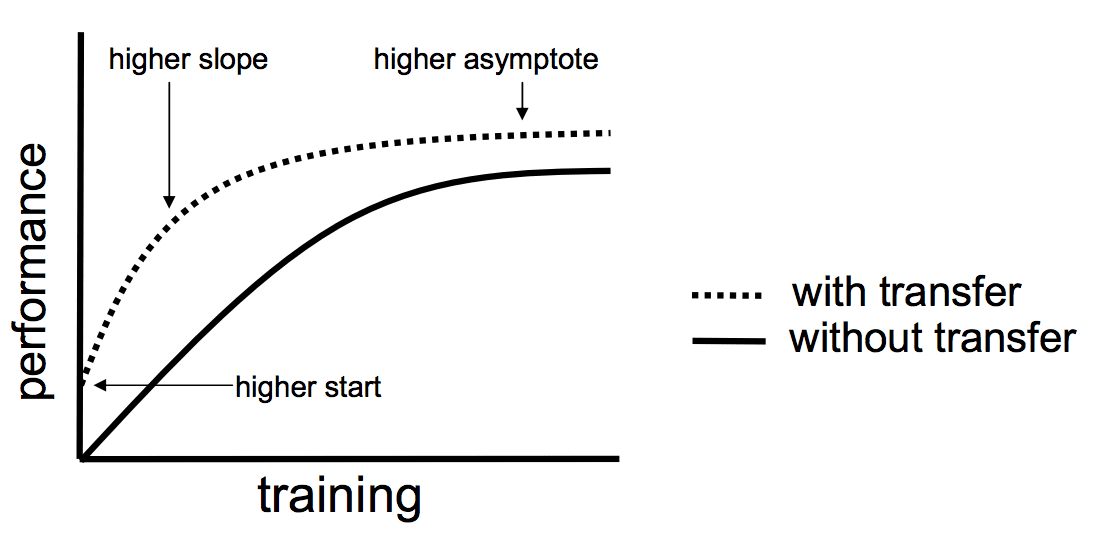

### Naive Intuition: Why does Transfer Learning work ?

Transfer learning "can be called" an inductive transfer. This is where the scope of possible models (model bias) is narrowed in a beneficial way by using a model fit on a different, but related task.

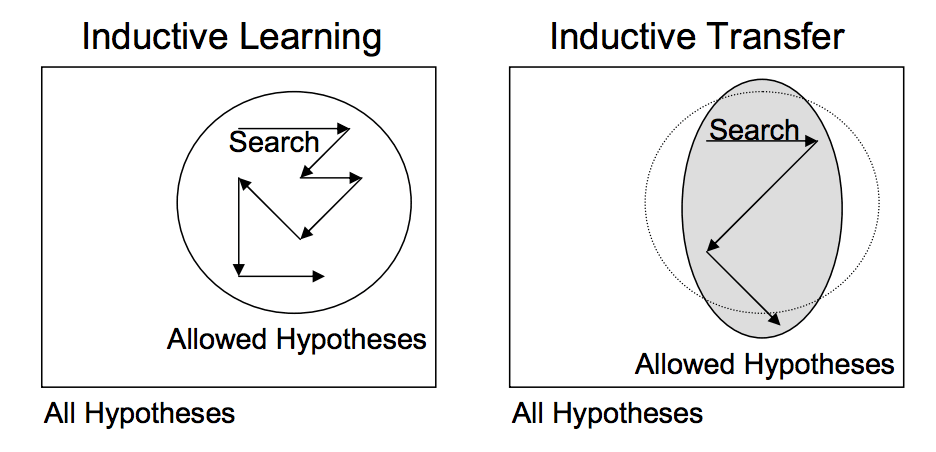

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForTokenClassification

# Lets construct tokenizer and model 
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased')
model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

> **TODO**: Read more about Bert : https://huggingface.co/docs/transformers/model_doc/bert

In [3]:
from transformers import pipeline

# Now lets try this model in Language modelling task
unmasker = pipeline('fill-mask', model='bert-base-uncased')
unmasker("Hello I'm a [MASK] model.")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'score': 0.10731066018342972,
  'token': 4827,
  'token_str': 'fashion',
  'sequence': "hello i'm a fashion model."},
 {'score': 0.08774455636739731,
  'token': 2535,
  'token_str': 'role',
  'sequence': "hello i'm a role model."},
 {'score': 0.05338381975889206,
  'token': 2047,
  'token_str': 'new',
  'sequence': "hello i'm a new model."},
 {'score': 0.04667207598686218,
  'token': 3565,
  'token_str': 'super',
  'sequence': "hello i'm a super model."},
 {'score': 0.027095964178442955,
  'token': 2986,
  'token_str': 'fine',
  'sequence': "hello i'm a fine model."}]

<a id='Sentence_classification_with_Transformers'></a>
# Sentence classification with Transformers

Let's take a look at some common metrics using NLP example [Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started):
![](https://storage.googleapis.com/kaggle-media/competitions/tweet_screenshot.png)

The author explicitly uses the word “ABLAZE” (палаючий) but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.
Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.

**Please check info about Kaggle API** [here](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwifhoe5_7mBAxXPGRAIHXuXAWIQFnoECBIQAw&url=https%3A%2F%2Fgithub.com%2FKaggle%2Fkaggle-api%23%3A~%3Atext%3DTo%2520use%2520the%2520Kaggle%2520API%2Cfile%2520containing%2520your%2520API%2520credentials.&usg=AOvVaw1BewOUEPrUy1mWsrqk8T5U&opi=89978449)

In [ ]:
import platform

!kaggle competitions download -c nlp-getting-started

# Check if using Windows or Unix-based system
if platform.system() == "Windows":
    !powershell -command Expand-Archive nlp-getting-started.zip -DestinationPath ..\data\nlp-getting-started -Force
else:
    !unzip nlp-getting-started.zip -d ../data/nlp-getting-started

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split


df_twitter = pd.read_csv('../data/nlp-getting-started/train.csv')
df_twitter.sample(5)

,id,keyword,location,text,target
338,485,armageddon,#FLIGHTCITY UK,(OFFICIAL VID) &gt; #DoubleCups &gt;&gt; https...,0
3226,4630,emergency%20services,"Whippany, NJ",Air Group is here to the rescue! We have 24/7 ...,0
1462,2110,catastrophe,"Wellington, New Zealand",@APPLEOFFIClAL Migrating from iPhoto to Photo ...,0
3544,5067,famine,NaN,According to a 2011 Gallup poll the more money...,0
5711,8149,rescuers,NaN,#world Fears over missing migrants in Med: Res...,1


In [5]:
MAX_LEN = int(df_twitter.text.str.split().apply(len).max()*1.5)

#straightforward train/test split

df_train, df_val = train_test_split(
    df_twitter, test_size=0.3, random_state=42, stratify=df_twitter.target, shuffle=True
)

df_twitter_test = pd.read_csv('../data/nlp-getting-started/test.csv')
df_twitter_test['target'] = 0

df_twitter_test.to_csv('../data/nlp-getting-started/test_0_target.csv', index=False)
df_train.to_csv('../data/nlp-getting-started/trf_train.csv', index=False)
df_val.to_csv('../data/nlp-getting-started/trf_val.csv', index=False)

## Preparation

### How does Transformer tokenizer work ?

Documentation link - https://huggingface.co/docs/transformers/main_classes/tokenizer

Transformer tokenizer is a very high level block, so it consumes plain text and returns:
- input_ids - Text tokens, already transformed to int (long)
- token_type_ids - type of token. This info is not used for casual Classification. But it is used for Q&A tasks. So in such a task you can just concatenate Question and Answer in one string and mark 0s for Question token_type_ids and 1s for Answer token_type_ids and then just classify if there is match with binary classification. We have used such an approach [here]( https://www.kaggle.com/competitions/company-acceptance-prediction/discussion/141609)
- attention_mask - Whether take into account token or not. It is pretty useful for padding. Check out `TextDataset` below 

Also tokenizer adds special tokens. Here are some examples:
- Bert tokens:
    - `[MASK]` - The token used for masking values. This is the token used when training this model with masked language modeling. This is the token which the model will try to predict.
    - `[CLS]` - The classifier token which is used when doing sequence classification (classification of the whole sequence instead of per-token classification). It is the first token of the sequence when built with special tokens.
    - `[SEP]` - The separator token, which is used when building a sequence from multiple sequences, e.g. two sequences for sequence classification or for a text and a question for question answering. It is also used as the last token of a sequence built with special tokens.
- RoBerta tokens:
    - `<s>` - The beginning of sequence token that was used during pretraining. Can be used a sequence classifier token.
    - `<\s>` - The separator token, which is used when building a sequence from multiple sequences, e.g. two sequences for sequence classification or for a text and a question for question answering. It is also used as the last token of a sequence built with special tokens.

In [6]:
tokenized_doc = tokenizer(df_train["text"].iloc[0])
tokenized_doc

{'input_ids': [101, 5869, 7136, 1999, 2327, 1019, 3655, 2005, 2417, 1011, 2422, 2770, 20871, 8299, 1024, 1013, 1013, 1056, 1012, 2522, 1013, 21117, 2620, 2080, 2620, 2487, 9818, 25619, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [7]:
print(f"Original Processed Text:\n{df_train['text'].iloc[0]}\n\n")
print(f"Transformed back Text after Tokenization:\n{' '.join(tokenizer.convert_ids_to_tokens(tokenized_doc['input_ids']))}")

Original Processed Text:
Las Vegas in top 5 cities for red-light running fatalities http://t.co/kC8O81BcHG


Transformed back Text after Tokenization:
[CLS] las vegas in top 5 cities for red - light running fatalities http : / / t . co / kc ##8 ##o ##8 ##1 ##bc ##hg [SEP]


### How does Transformer classify sentence?

Conceptually it works pretty similar to Reccurent Nets (previous lecture) in the mean that it encodes tokens and produce some sequence of encoded tokens. BUT we need to supply to the classification layer only one embedding, not a sequence. How to choose it? 

It is a good question. There are plenty of ways what exact representations to take, but there are two most popular:

1. **Classify only [CLS] token** - In such an approach, the Transformer will accumulate all primary sentence information in the [CLS] token. 

![](https://d2l.ai/_images/bert-one-seq.svg)

2. **Average all tokens** - In such an approach, we average all the extracted information. In some cases such an approach outperfoms the first one.

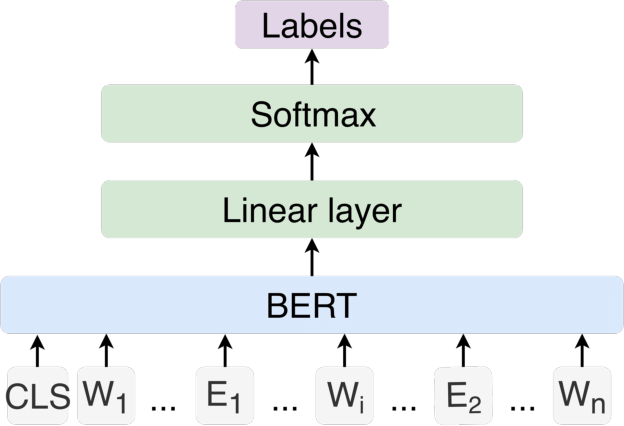

> **TODO**: Read about other approaches for extracting "sentence" vector for Text classification

In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset

# Load your CSV file
dataset = load_dataset('csv', data_files={
    'train': '../data/nlp-getting-started/trf_train.csv',
    'val': '../data/nlp-getting-started/trf_val.csv',
    'test': '../data/nlp-getting-started/test_0_target.csv'
})
dataset = dataset.rename_column("target", "labels")
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'labels'],
        num_rows: 5329
    })
    val: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'labels'],
        num_rows: 2284
    })
    test: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'labels'],
        num_rows: 3263
    })
})

In [9]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    ignore_mismatched_sizes=True
)

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=int(MAX_LEN))

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/5329 [00:00<?, ? examples/s]

Map:   0%|          | 0/2284 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

In [10]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5329
    })
    val: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2284
    })
    test: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3263
    })
})

In [11]:
BATCH_SIZE = 64
NUM_EPOCHS = 2

training_args = TrainingArguments(
    'twitter_bert_checkpoints',
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True
)

### Specific Scheduler and Optimization  

Transformers tend to overfit very fast and also their training process is not so trivial as for Recurrent Nets.

In this specific case we will use next 2 tricks:
1. Different learning rates for Encoder Net and Classification head. The main idea here is that:
    - Pre-trained Encoder Net is well fitted and we do not want it to cardinally change it weights. Such startegy helps to prevent overfitting to the specific dataset and at the same time prevents `Catastrophic forgetting` (when Neural Net forgets general linguistic concepts).
    - Classification Net is randomly initialized and it should be well fitted for specific task.
2. Learning rate scheduling with Warmup:
    - We will update learning rate more rapidly - after each iteration (batch), NOT after each epoch. Helps to get into a better local minimum.
    - We will first increase it and then decrease it. Helps not to get in a bad local minimum from the start.

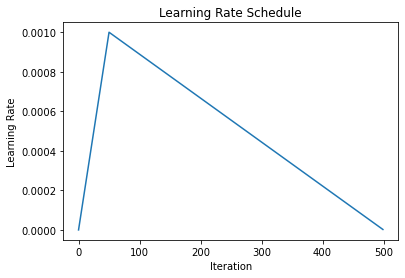

In [12]:
import torch
from matplotlib import pyplot as plt
from transformers import AdamW, get_linear_schedule_with_warmup

def visualise_lr_scheduling(lr_scheduler_from_opt, n_steps, verbose=True, lr=1e-3):
    t_opt = torch.optim.SGD([torch.tensor(1)], lr=lr)
    t_sched = lr_scheduler_from_opt(t_opt)
    lrs = []
    for i in range(n_steps):
        t_opt.step()
        lrs.append(t_sched.get_lr()[0])
        t_sched.step()
    if verbose:
        plt.title("Learning Rate Schedule")
        plt.xlabel("Iteration")
        plt.ylabel("Learning Rate")
        plt.plot(lrs)
        plt.show()
    return lrs


visualise_lr_scheduling(
    lr_scheduler_from_opt=lambda opt: get_linear_schedule_with_warmup(
        optimizer=opt, 
        num_warmup_steps=50, 
        num_training_steps=500
    ),
    n_steps=500,
    lr=1e-3
);

In [13]:
from sklearn.metrics import f1_score
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"f1": f1_score(labels, predictions, average='macro')}


optimizer = AdamW([
    {'params': list(model.bert.parameters()), 'lr': 1e-5},
    {'params': list(model.classifier.parameters()), 'lr': 1e-3}
])


NUM_STEPS = int(NUM_EPOCHS*tokenized_datasets['train'].num_rows/BATCH_SIZE)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1*NUM_STEPS),
    num_training_steps=NUM_STEPS
)

/home/ubuntu/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['val'], 
    optimizers=(optimizer, scheduler),
    compute_metrics=compute_metrics
)

In [15]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.535600,0.409430,0.820034
2,0.390100,0.399509,0.828064


Checkpoint destination directory twitter_bert_checkpoints/checkpoint-84 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory twitter_bert_checkpoints/checkpoint-168 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=168, training_loss=0.46281510307675316, metrics={'train_runtime': 39.0019, 'train_samples_per_second': 273.269, 'train_steps_per_second': 4.307, 'total_flos': 251943224393040.0, 'train_loss': 0.46281510307675316, 'epoch': 2.0})

> **TODO**: Check if this configuration really leads to overfit after epoch=2

In [16]:
preds = trainer.predict(tokenized_datasets['test'])
submission = pd.read_csv('../data/nlp-getting-started/sample_submission.csv')
submission['target'] = preds.predictions.argmax(axis=1)
submission.to_csv('bert_base_uncased_submission.csv', index=False)

![](./images/bert_clf_lb.png)

> **TODO**: Check token classification / NER task in Lecture 5

## Comparing Transformers to Recurrent Nets

**Pros**
+ Shows better performance in terms of metrics.
+ Take into account all context.
+ Requires less text preprocessing.
+ Because of Attention matrices - may be better interpretabile.

**Cons**
- Much harder to train.
- Overfits pretty fast.
- Harder to deploy.
- Requires GPU for both training and inference.
- Works longer.

<a id='gpt_intro'></a>
# [Theory] Intro to GPT

> **Explore**: Very well detailed video about GPT from scratch: https://www.youtube.com/watch?v=kCc8FmEb1nY   
> Thanks @Andrii Shevtsov for the link

---
**Generative pre-trained transformers (GPT)** models, including [GPT-1](https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf), [GPT-2](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf), and [GPT-3](https://arxiv.org/pdf/2005.14165.pdf), are **decoder-only** Transformer models. In the original ["Attention is All You Need" paper](https://arxiv.org/pdf/1706.03762.pdf) that introduced the Transformer architecture, the model was presented as an encoder-decoder architecture. However, in the case of GPT models, the encoder component is omitted, and only the decoder stack is used.


### Auto-regressive generation

Approach when model generates text or language sequentially, word by word or token by token, with each word being dependent on the preceding words in the sequence is called auto-regressive. This approach is "auto-regressive" because the model uses its own previously generated words as context to predict and generate the next word. 

Auto-regressive language generation is based on the assumption that the probability distribution of a word sequence can be decomposed into the product of conditional next word distributions:
$$\large P(w_{1:T}|W_0) = \prod_{t=1}^T P(w_t|w_{1:t-1}, W_0),\;with\;w_{1:0}=∅$$

and $W_0$ being the initial context word sequence.

The length $T$ of the word sequence is usually determined on-the-fly and corresponds to the timestep $t=T$ the `<EOS>` token is generated from $P(w_t|w_{1:t-1}, W_0)$.

![ar](images/text-gen-diagram.png)


The GPT model is performing autoregressive text generation. In this context, they operate solely as decoders, producing text one word at a time based on the preceding context. This makes them well-suited for tasks like text completion, text generation, and natural language understanding.

### Ways of selecting tokens
#### Greedy search

Greedy search is the simplest decoding method. It selects the word with the highest probability as its next word $w_t=argmax_w P(w∣w_{1:t−1})$ at each timestep $t$.

![](./images/greedy_search.png)

The major drawback of greedy search though is that it misses high probability words hidden behind a low probability word as can be seen in our sketch above:

#### Sampling

Sampling means randomly picking the next word $w_t$ according to its conditional probability distribution:

$$\large w_t∼P(w ∣ w_{1:t−1})$$

We can further improve this by modifing the pool of words we use for it, or by weighting the probabilities of words.

> **TODO**: read about *temprature* for [softmax](https://en.wikipedia.org/wiki/Softmax_function#Smooth_arg_max) function.

Commonly,Top-K sampling is performed:

1. The language model generates a probability distribution over the entire vocabulary for the next token in the sequence.

2. It ranks the tokens by their probabilities in descending order.

3. It identifies the top-k tokens with the highest probabilities. "k" is a predefined threshold that determines how many tokens to consider.

4. The model randomly samples from this set of top-k tokens to choose the next token in the sequence.

The top-k sampling method ensures that the next token is chosen from a restricted set of possibilities, which can be especially useful in text generation to control the output's quality and coherence. It balances between deterministic (by selecting only the top-k tokens) and more random (by allowing some variability in the selected token) generation.

#### Example with K=6:
![%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%BD%D1%8F.png](./images/sampling.png)

> **TODO**: read about top-p (nucleus) sampling.

# Evolution of GPT: Model Scaling

Here are the key differences between GPT-1, GPT-2, and GPT-3:

**Model Size:**

* GPT-1: GPT-1 is a smaller model with around 117 million parameters.
* GPT-2: GPT-2 is a large model, available in several different sizes with the largest having 1.5 billion parameters.
* GPT-3: GPT-3 is considerably larger, with its largest version having a whopping 175 billion parameters.

**Data and Pre-training:**

* GPT-3: GPT-3 was pre-trained on an even more extensive and diverse dataset compared to GPT-2. It has access to a vast amount of text data from the internet, allowing it to capture a broader range of language patterns and knowledge.
* GPT-1 and GPT-2 had access to different datasets but are smaller in scale compared to GPT-3.

**Fine-tuning:**

* All three models can be fine-tuned on specific tasks, but GPT-3's scale and performance make it more versatile and powerful in fine-tuned applications.

**Performance:**

* GPT-3: GPT-3 significantly outperforms GPT-2 in terms of natural language understanding and generation. It excels in a wide range of NLP tasks, from text completion to translation, and it often achieves state-of-the-art results on various benchmarks.
* GPT-1 and GPT-2 have their respective performance levels, but GPT-3 surpasses both in most NLP tasks.

**Applications:**

* GPT-3 is designed for a wide array of natural language processing tasks, including text generation, language translation, question answering, and much more. Its versatility makes it suitable for many practical applications.
* GPT-1 and GPT-2 are also capable language models, but they may not perform as well as GPT-3 across such a broad spectrum of tasks.

In summary, GPT-3 represents a significant advancement over GPT-1 and GPT-2 in terms of model size, performance, and versatility. Its larger scale and improved training data make it a more powerful tool for various natural language understanding and generation tasks.

# InstructGPT

Making language models bigger does not inherently make them better at following a user’s intent. For example, large language models can generate outputs that are untruthful, toxic, or simply not helpful to the user. For that, OpenAI utilized different fine tuning to get better results on diffent tasks and called those models InstructGPT.

**Main idea:**
Human reviewers rank model responses, and the models are fine-tuned based on this feedback. The method is called **Reinforcement Learning from human feedback**.
 
[Reinforcement Learning from Human Feedback (RLHF)](https://arxiv.org/pdf/1909.08593.pdf) is a machine learning approach that combines reinforcement learning with human feedback to train or fine-tune models. It's a technique that leverages human expertise to improve the performance of AI models, especially in cases where the model's initial behavior may not align with desired outcomes or where creating a reward model is challenging.

For the GPT case, to get ChatGPT and other InstructGPT models, the following scheme was used:

### Step 1: Supervised Fine-tuning of GPT-3.5
In the first step, a prompt dataset is formed which consists of prompts from various domains. Then we take a prompt one by one and provide it to a labeler that will figure out the most desirable output for that prompt. Then the prompts and these human labels are combined to form a new dataset which is used by pre-trained GPT-3.5 for fine-tuning. This helps the model in learning what kind of outputs humans expect and desire.

![](./images/rlhf_1.png)

### Step 2: Training a Reward model
In the second step, we provide the language model with a prompt and extract several outputs from it. After the model has produced multiple outputs, a labeler will fill out a form shown below for each output. The labeler will give a rating to the output and answer a few categorical questions. These categorical questions tell what was wrong with the output. 

![](./images/rlhf_2.png)

![](./images/review_form.png)

All these labels and responses from the model are now used to train a rewards model. The reward model will take two responses from one prompt and calculate a reward r for each response. The loss function for this model is calculated based on human labels and rewards assigned by the reward model. If the first response is better i.e. reward is more for the first response then the loss will be low but if the second response is better then loss will be high.

### Step 3: Updating policy using PPO
In the third step, we input a new prompt to the fine-tuned GPT-3.5 obtained from the first step. This model will generate a response for this prompt. We will take this prompt and response, and use it as input to our trained Reward model from the second step. The reward model will a reward value to the response. We will use this reward to train our fine-tuned GPT-3.5. The model has to learn to maximize the reward value.

![](./images/rlhf_3.png)

The fine-tuned GPT-3.5 is updated by using the reward form reward model. The model is updated with the help of Proximal policy optimization. The goal of PPO is to maximize the total reward of responses generated from the model by including reward in the loss.


> **TODO**: Check Training a Small GPT Model and LoRA finetuning in Lecture 6

# References
- https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data
- https://arxiv.org/abs/1706.03762
- https://medium.com/@corymaklin/transformers-explained-610b2f749f43
- https://vaclavkosar.com/ml/cross-attention-in-transformer-architecture
- https://medium.com/nlplanet/two-minutes-nlp-most-used-decoding-methods-for-language-models-9d44b2375612
- https://www.tensorflow.org/text/tutorials/transformer
- https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a
- https://en.wikipedia.org/wiki/Language_model
- https://machinelearningmastery.com/transfer-learning-for-deep-learning/
- https://medium.com/nlplanet/two-minutes-nlp-most-used-decoding-methods-for-language-models-9d44b2375612
- https://image-net.org/
- https://huggingface.co/
- https://github.com/huggingface/transformers
- https://huggingface.co/models
- https://huggingface.co/datasets
- https://huggingface.co/spaces
- https://huggingface.co/docs/transformers/model_doc/bert
- https://huggingface.co/docs/transformers/model_doc/roberta
- https://huggingface.co/docs/transformers/main_classes/tokenizer
- https://www.kaggle.com/competitions/company-acceptance-prediction/discussion/141609
- https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html
- https://huggingface.co/docs/transformers/tasks/token_classification
- https://pytorch-lightning.readthedocs.io/en/1.6.0/ecosystem/transformers.html
- https://huggingface.co/docs/transformers/tasks/sequence_classification